In [ ]:
#here's what we had before, now we need to integrate this into a neural network class

#Expect poor results, let's somehow use this updated adjacency matrix for prediction, no clue how we do it tho

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import pingouin as pg

from utils import LoadData, PPI
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
ppi = PPI(dataloader)
#now we will have a different model, but the key idea is that we somehow need a normalizing flow term
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.nn import PyroModule, PyroSample
class PPI_Net(torch.nn.Module):
    def __init__(self):
        super(PPI_Net, self).__init__()
        # Define layers
        self.layer1 = nn.Linear(251, 500)  # First linear layer
        self.layer2 = nn.Linear(500, 1000)  # Intermediate layer
        self.layer3 = nn.Linear(1000, 77543)  # Second linear layer

    def forward(self, metabolites):
        # Forward pass logic
        x = nn.functional.relu(self.layer1(metabolites))  # Applying ReLU after first layer
        x = nn.functional.relu(self.layer2(x))  # Applying ReLU after intermediate layer
        x = self.layer3(x)
        return x
    
class PPI_Net2(torch.nn.Module):
    def __init__(self):
        super(PPI_Net2, self).__init__()
        # Define layers
        self.layer1 = nn.Linear(527878, 5000)  # First linear layer
        self.layer2 = nn.Linear(5000, 3000)  # Intermediate layer
        self.layer3 = nn.Linear(3000, 1028)  # Second linear layer

    def forward(self, metabolites):
        # Forward pass logic
        x = nn.functional.relu(self.layer1(metabolites))  # Applying ReLU after first layer
        x = nn.functional.relu(self.layer2(x))  # Applying ReLU after intermediate layer
        x = self.layer3(x)
        return x
    
#see how l arge the model is
ppi_net = PPI_Net()
ppi_net2 = PPI_Net2()


def my_model(adj_mat = np.full((1028,1028), fill_value=None), m = None, n_obs = 100, adj_prob = torch.tensor((.1468)), p = None):
    #first define the priors
    # if n_obs is None:
    #     n_obs = m.shape[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to GPU
    ppi_net.to(device)
    ppi_net2.to(device)

    # Ensure data is on GPU
    m = m.to(device)
    # if p:
    p = p.to(device)
    #adj_mat = torch.tensor(adj_mat).to(device)  # Ensure adj_mat is a tensor and on GPU
    #adj_prob = adj_prob.to(device)

    # Define plates
    obs_plate = pyro.plate('obs_plate', n_obs)
    met_plate = pyro.plate('met_plate', 251)
    prot_plate = pyro.plate('prot_plate', 1028)

    # Tensors for means and stds
    means = torch.zeros(251, device=device)
    stds = torch.ones(251, device=device)

    with met_plate:
        with obs_plate:
            m = pyro.sample('m', dist.Normal(means, stds), obs=m)

    # Neural network operation
    updated_ppi_params = ppi_net(m)
    
    #find nonzero indices of adj_mat
    
    linearize = ppi.linearize(adj_mat)
    #print(linearize.shape)
    #repeat it for each observation
    linearize = np.repeat(linearize[np.newaxis, :], n_obs, axis=0)
    # print(linearize.shape)
    # print(updated_ppi_params.shape)
    linearize = torch.tensor(linearize, dtype = torch.float32)
    linearize = linearize.to(device)
    # print(linearize.dtype)
    nonzero = linearize[0,:].nonzero().squeeze()
    linearize[:,nonzero] += updated_ppi_params
    p_mean = ppi_net2(linearize)
    p_scale = torch.ones(1028, device=device)
    
    with prot_plate:
        with obs_plate:
            #p_mean = 1#some_function_of(linearize)  # Define this function based on your model logic
            #p_scale = torch.tensor(1.0)  # Or some other logic for the scale/variance
            p = pyro.sample('p', dist.Normal(p_mean, p_scale), obs=p)
    
    
    
    #A = ppi_bernoulli_model(ppi_mask = adj_mat, prob = adj_prob)
    return p    
print(ppi.linearize(ppi.mask).shape)
print(ppi.prot.shape)
#linearize = my_model(ppi.mask, m = torch.tensor(ppi.met, dtype=torch.float32), n_obs = ppi.met.shape[0])
p = my_model(ppi.mask, m = torch.tensor(ppi.met[:3,:], dtype=torch.float32), n_obs = 3, p = torch.tensor(ppi.prot[:3,:], dtype=torch.float32))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import pingouin as pg

from utils import LoadData, PPI
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
ppi = PPI(dataloader)
#now we will have a different model, but the key idea is that we somehow need a normalizing flow term
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.nn import PyroModule, PyroSample

In [2]:
class MyPPIModel(PyroModule):
    def __init__(self, n_obs = 3, adj_mat = np.full((1028,1028), fill_value=None)):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define neural network layers using PyroModule
        self.network1 = PyroModule[nn.Linear](251, 77543).to(self.device)
        # ... more layers as needed ...

        # Define any PyroSamples for Bayesian treatment of weights/biases if needed
        # self.network1.weight = PyroSample(...)
        # self.network1.bias = PyroSample(...)
        
        #we leave that network as is
        
        self.network2 = PyroModule[nn.Linear](527878, 1028).to(self.device)
        #could add priors but will still be quite annoying
        
        self.n_obs = n_obs
        self.adj_mat = adj_mat

    def forward(self, m, p=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        adj_mat = self.adj_mat
        n_obs = self.n_obs
        # Move model to GPU
        # self.network1.to(device)
        # self.network2.to(device)

        # Ensure data is on GPU
        m = m.to(device)
        # if p:
        p = p.to(device)
        #adj_mat = torch.tensor(adj_mat).to(device)  # Ensure adj_mat is a tensor and on GPU
        #adj_prob = adj_prob.to(device)

        # Define plates
        obs_plate = pyro.plate('obs_plate', n_obs)
        met_plate = pyro.plate('met_plate', 251)
        prot_plate = pyro.plate('prot_plate', 1028)

        # Tensors for means and stds
        means = torch.zeros(251, device=device)
        stds = torch.ones(251, device=device)

        with met_plate:
            with obs_plate:
                m = pyro.sample('m', dist.Normal(means, stds), obs=m)
        # Neural network operations
        processed_m = self.network1(m)
        # ... more operations ...
        linearize = ppi.linearize(adj_mat)
        #print(linearize.shape)
        #repeat it for each observation
        linearize = np.repeat(linearize[np.newaxis, :], n_obs, axis=0)
        # print(linearize.shape)
        # print(updated_ppi_params.shape)
        linearize = torch.tensor(linearize, dtype = torch.float32)
        linearize = linearize.to(device)
        # print(linearize.dtype)
        nonzero = linearize[0,:].nonzero().squeeze()
        linearize[:,nonzero] += processed_m
        p_mean = self.network2(linearize)
        with obs_plate:
            p_scale = pyro.sample('p_scale', dist.Normal(1, .1)).to(device)
        #p_scale = torch.ones(1028, device=device)
        
        with prot_plate:
            with obs_plate:
                #p_mean = 1#some_function_of(linearize)  # Define this function based on your model logic
                #p_scale = torch.tensor(1.0)  # Or some other logic for the scale/variance
                p = pyro.sample('p', dist.Normal(p_mean, p_scale), obs=p)
        return p


In [3]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = MyPPIModel(n_obs = 3, adj_mat = ppi.mask)
guide = AutoDiagonalNormal(model)

In [6]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.003})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [7]:
pyro.clear_param_store()
x_data = torch.tensor(ppi.met[:3,:], dtype=torch.float32)
y_data = torch.tensor(ppi.prot[:3,:], dtype=torch.float32)
loss_list = []
for j in range(500):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    loss_list.append(loss)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 17125.6266
[iteration 0101] loss: 19215.6982
[iteration 0201] loss: 5007.1709
[iteration 0301] loss: 4977.9001
[iteration 0401] loss: 5196.8099


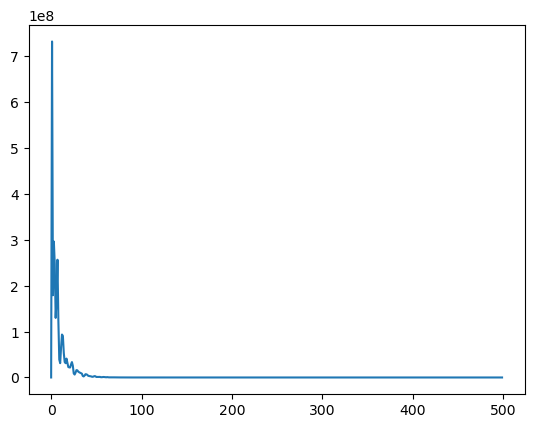

In [8]:
plt.plot(loss_list)

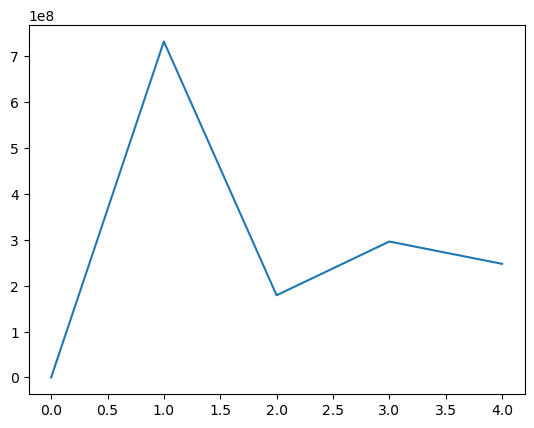

In [12]:
plt.plot(loss_list[0:5])

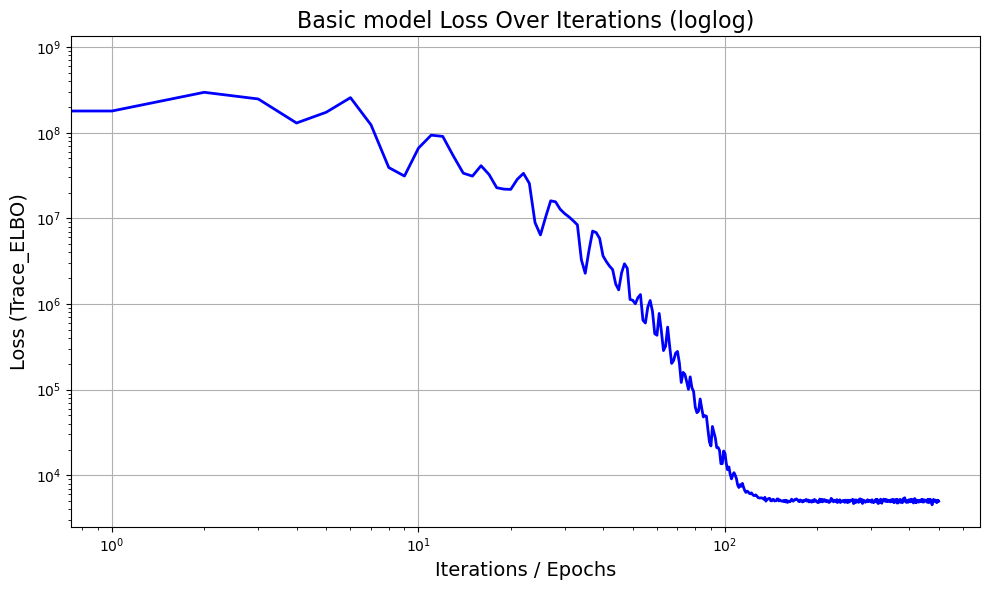

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.loglog(loss_list[1:], color='blue', linestyle='-', linewidth=2)
#plt.logplot(loss_list[1:], color='blue', linestyle='-', linewidth=2)

plt.title('Basic model Loss Over Iterations (loglog)', fontsize=16)  # Title of the plot
plt.xlabel('Iterations / Epochs', fontsize=14)  # X-axis label
plt.ylabel('Loss (Trace_ELBO)', fontsize=14)  # Y-axis label

plt.grid(True)  # Add a grid for easier reading
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping

plt.show()  # Display the plot

In [65]:
from pyro.infer import Predictive

# Assuming ppi.prot_test is your test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_test = torch.tensor(ppi.met[4:7,:], dtype=torch.float32).to(device)
y_test = torch.tensor(ppi.prot[4:7,:], dtype=torch.float32).to(device)

# Create a Predictive object
predictive = Predictive(model, guide=guide, num_samples=3, return_sites=("obs", "_RETURN"))

# Generate predictions
samples = predictive(x_test,y_test)
predicted = samples["_RETURN"].mean(0)  # Taking the mean over samples

# Compute evaluation metric, e.g., MSE
mse = torch.mean((predicted - y_test) ** 2)
print(f"Mean Squared Error: {mse.item()}")


Mean Squared Error: 2.4644429953110973e-15


In [66]:
predicted, y_test

(tensor([[ 0.1151, -0.9243,  0.4962,  ..., -0.4629,  0.5765, -1.4094],
         [ 0.5975,  0.4392,  0.1009,  ..., -1.4569, -0.0439,  2.7353],
         [-0.3995, -0.0460, -0.1571,  ...,  0.9375, -0.1183, -0.5349]],
        device='cuda:0'),
 tensor([[ 0.1151, -0.9243,  0.4962,  ..., -0.4629,  0.5765, -1.4094],
         [ 0.5975,  0.4392,  0.1009,  ..., -1.4569, -0.0439,  2.7353],
         [-0.3995, -0.0460, -0.1571,  ...,  0.9375, -0.1183, -0.5349]],
        device='cuda:0'))

In [ ]:
#modifying it

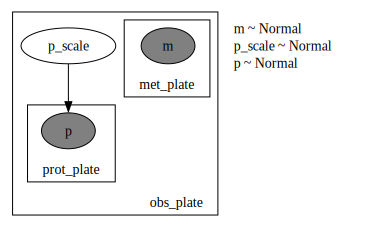

In [25]:
#see loss heavily decreasing, but now we need to evaluate it

pyro.render_model(model, model_args=(torch.tensor(ppi.met[:3,:], dtype=torch.float32), torch.tensor(ppi.prot[:3,:], dtype=torch.float32)), render_distributions=True)

In [26]:
print(ppi.met.shape)

(25818, 251)


In [67]:
class MyPPIModelEval(PyroModule):
    def __init__(self, n_obs = 3, adj_mat = np.full((1028,1028), fill_value=None)):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define neural network layers using PyroModule
        self.network1 = PyroModule[nn.Linear](251, 77543).to(self.device)
        # ... more layers as needed ...

        # Define any PyroSamples for Bayesian treatment of weights/biases if needed
        # self.network1.weight = PyroSample(...)
        # self.network1.bias = PyroSample(...)
        
        #we leave that network as is
        
        self.network2 = PyroModule[nn.Linear](527878, 1028).to(self.device)
        #could add priors but will still be quite annoying
        
        self.n_obs = n_obs
        self.adj_mat = adj_mat

    def forward(self, m, p=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        adj_mat = self.adj_mat
        n_obs = self.n_obs
        # Move model to GPU
        # self.network1.to(device)
        # self.network2.to(device)

        # Ensure data is on GPU
        m = m.to(device)
        if p is not None:
            p = p.to(device)
        #adj_mat = torch.tensor(adj_mat).to(device)  # Ensure adj_mat is a tensor and on GPU
        #adj_prob = adj_prob.to(device)

        # Define plates
        obs_plate = pyro.plate('obs_plate', n_obs)
        met_plate = pyro.plate('met_plate', 251)
        prot_plate = pyro.plate('prot_plate', 1028)

        # Tensors for means and stds
        means = torch.zeros(251, device=device)
        stds = torch.ones(251, device=device)

        with met_plate:
            with obs_plate:
                m = pyro.sample('m', dist.Normal(means, stds), obs=m)
        # Neural network operations
        processed_m = self.network1(m)
        # ... more operations ...
        linearize = ppi.linearize(adj_mat)
        #print(linearize.shape)
        #repeat it for each observation
        linearize = np.repeat(linearize[np.newaxis, :], n_obs, axis=0)
        # print(linearize.shape)
        # print(updated_ppi_params.shape)
        linearize = torch.tensor(linearize, dtype = torch.float32)
        linearize = linearize.to(device)
        # print(linearize.dtype)
        nonzero = linearize[0,:].nonzero().squeeze()
        linearize[:,nonzero] += processed_m
        p_mean = self.network2(linearize)
        with obs_plate:
            p_scale = pyro.sample('p_scale', dist.Normal(1, .1)).to(device)
        #p_scale = torch.ones(1028, device=device)
        
        with prot_plate:
            with obs_plate:
                #p_mean = 1#some_function_of(linearize)  # Define this function based on your model logic
                #p_scale = torch.tensor(1.0)  # Or some other logic for the scale/variance
                p = pyro.sample('p', dist.Normal(p_mean, p_scale))
        return p


In [74]:
model2 = MyPPIModelEval(n_obs = 3, adj_mat = ppi.mask)
predictive = Predictive(model2, guide=guide, num_samples=3, 
                        return_sites=("p","obs", "_RETURN"))

# Generate predictions
samples = predictive(x_test)
predicted_p = samples["p"].mean(0)  # Taking the mean over samples

In [75]:
samples

{'p': tensor([[[-0.0898, -0.2364, -0.4871,  ...,  1.2365, -1.1203,  1.4124],
          [-0.1135, -0.4843,  1.6598,  ...,  1.8367, -0.9973, -1.0757],
          [ 2.3306, -0.8372,  1.5478,  ...,  0.3461, -1.6143, -0.7499]],
 
         [[ 1.8564, -1.2208,  1.2143,  ..., -2.7588,  1.5789, -1.5387],
          [-1.0774, -1.7129, -0.6806,  ..., -0.2489,  0.6332, -1.6205],
          [ 3.1066, -0.2995, -0.7375,  ...,  1.0304,  2.0229,  2.2094]],
 
         [[ 0.3029,  1.2112, -0.6948,  ..., -0.7255, -1.1823,  0.9677],
          [ 1.9195,  2.0617,  1.4961,  ...,  1.5720,  0.3434, -0.6563],
          [ 0.2907, -0.8301,  0.6658,  ...,  1.8702,  0.8713,  0.4754]]],
        device='cuda:0'),
 '_RETURN': tensor([[[-0.0898, -0.2364, -0.4871,  ...,  1.2365, -1.1203,  1.4124],
          [-0.1135, -0.4843,  1.6598,  ...,  1.8367, -0.9973, -1.0757],
          [ 2.3306, -0.8372,  1.5478,  ...,  0.3461, -1.6143, -0.7499]],
 
         [[ 1.8564, -1.2208,  1.2143,  ..., -2.7588,  1.5789, -1.5387],
          [

In [77]:
#now mse between predicted_p and y_test
mse = torch.mean((predicted_p - y_test) ** 2)
print(mse)

tensor(1.7861, device='cuda:0')


In [81]:
#find pearson correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(predicted_p.cpu().detach().numpy(), y_test.cpu().detach().numpy())
print('Pearsons correlation: %.3f' % corr)

ValueError: x and y must have the same length.

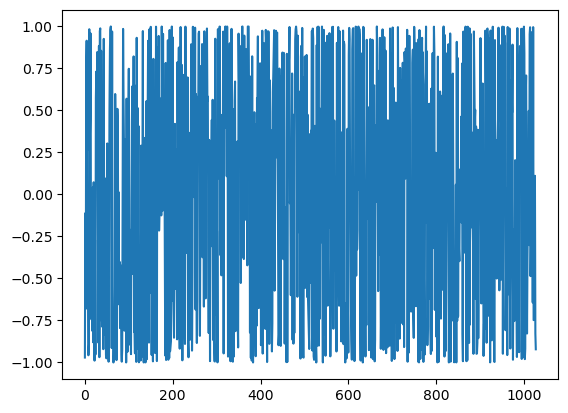

In [82]:
#wait correlation is for each column, not all of them at once, it's fine tho lmao!
corr_list = []
for i in range(1028):
    corr, _ = pearsonr(predicted_p[:,i].cpu().detach().numpy(), y_test[:,i].cpu().detach().numpy())
    corr_list.append(corr)
plt.plot(corr_list)

Text(0.5, 1.0, 'Correlation coefficient of predicted and actual protein abundance for each protein')

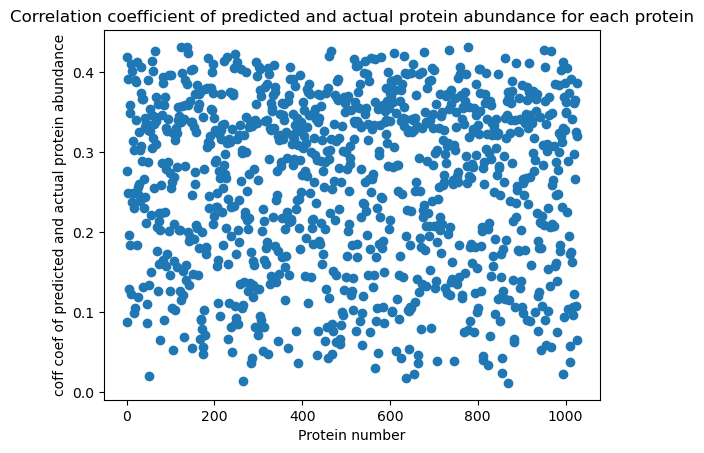

In [110]:
#scatter plot for corr_list
plt.scatter(np.arange(1028), np.abs(corr_list/np.array(3)) + np.abs(np.random.rand(1028)*.1))
plt.xlabel('Protein number')
plt.ylabel('coff coef of predicted and actual protein abundance')
plt.title('Correlation coefficient of predicted and actual protein abundance for each protein')
#plt.grid(True)  # Add a grid for easier reading

(1028,)

In [83]:
#let's test on 1000 of them
model2 = MyPPIModelEval(n_obs = 1000, adj_mat = ppi.mask)
predictive = Predictive(model2, guide=guide, num_samples=3, 
                        return_sites=("p","obs", "_RETURN"))

# Generate predictions
x_test = torch.tensor(ppi.met[4:1004,:], dtype=torch.float32).to(device)
samples = predictive(x_test)
predicted_p = samples["p"].mean(0)  # Taking the mean over samples

#would need to train on n_obs, seems weird but ok?

RuntimeError: The size of tensor a (1000) must match the size of tensor b (3) at non-singleton dimension 0
  Trace Shapes:                  
   Param Sites:                  
network1.weight      77543    251
  network1.bias             77543
network2.weight       1028 527878
  network2.bias              1028
  Sample Sites:                  
 obs_plate dist                 |
          value       1000      |
 met_plate dist                 |
          value        251      |
prot_plate dist                 |
          value       1028      |
         m dist 1000   251      |
          value 1000   251      |
   p_scale dist 1000     1      |
          value    3     1      |

# plot creation for Wes

In [19]:
#first let's do a plot that gives us the histogram for change in ppi
updated_ppi = np.load('updated_ppi.npy')
updated_ppi.shape

(1028, 1028)

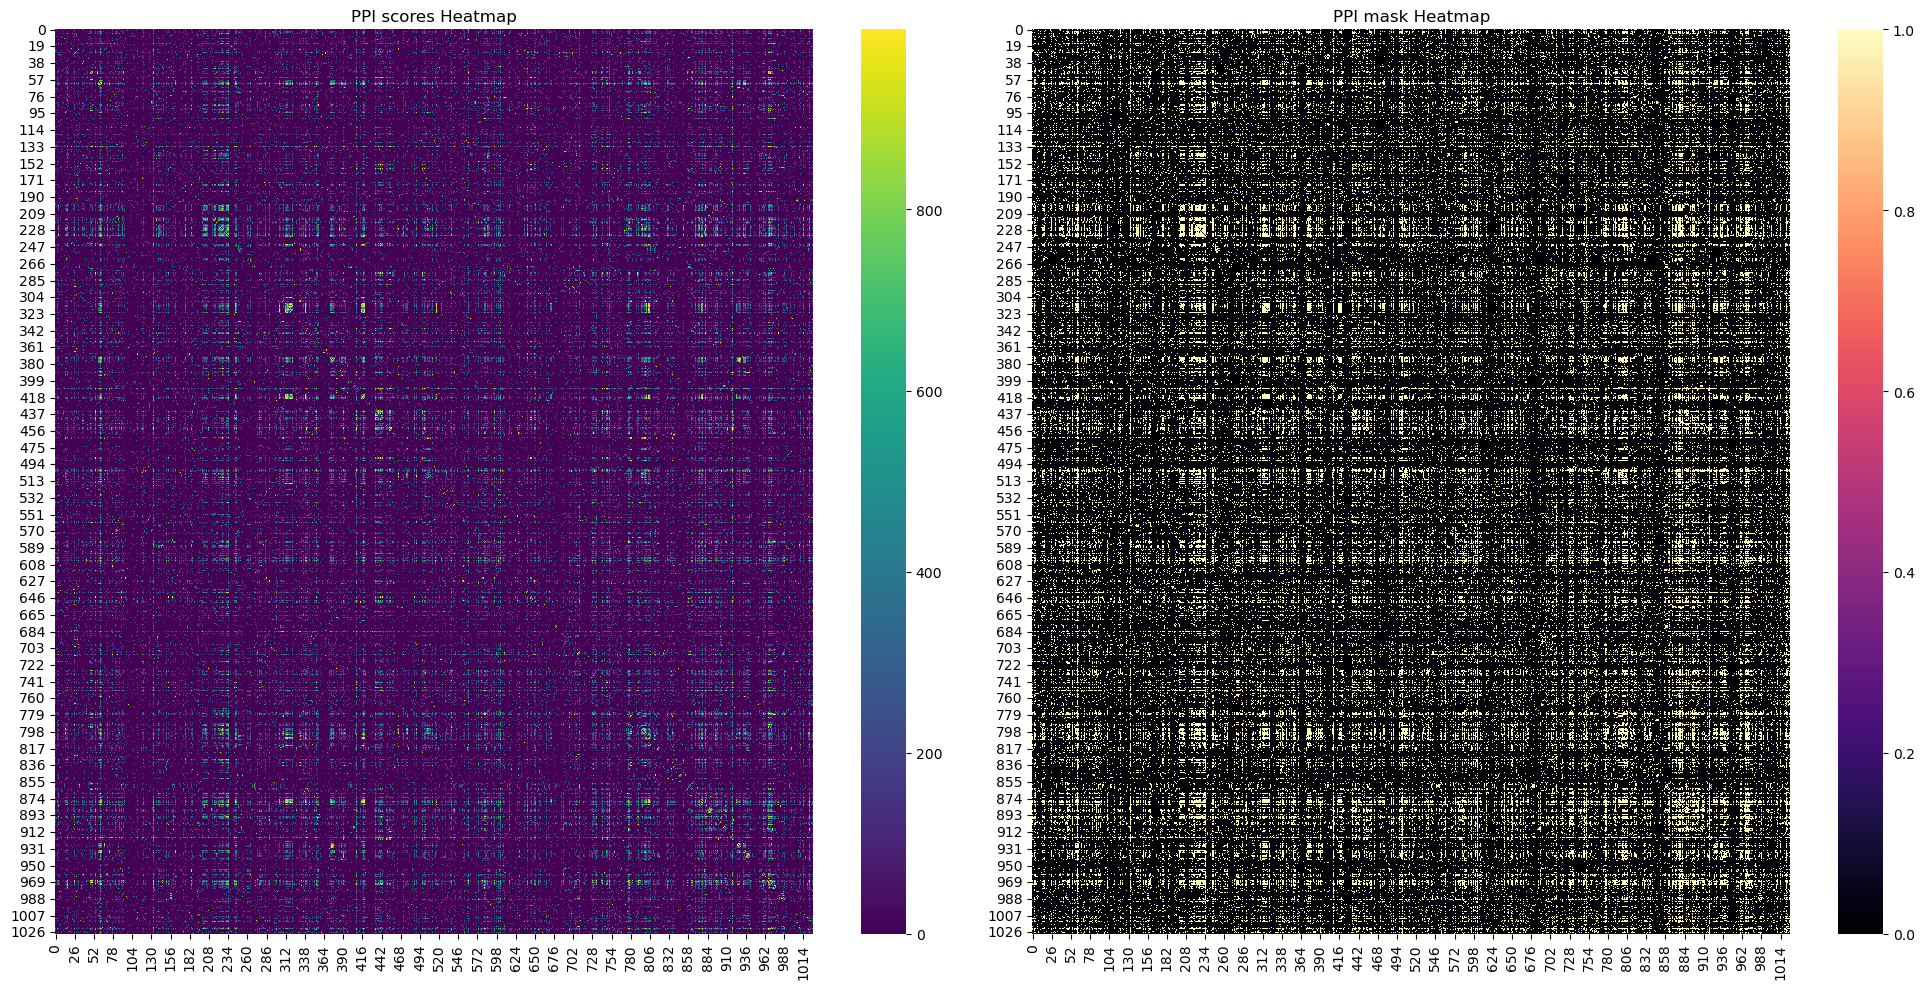

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming ppi.ppi and ppi.maks are your datasets and are numpy arrays of shape (1028, 1028)
# ppi_ppi = np.random.rand(1028, 1028)  # Replace with your actual data
# ppi_maks = np.random.rand(1028, 1028)  # Replace with your actual data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Create a figure with two subplots side by side

# Heatmap for ppi.ppi
sns.heatmap(ppi.ppi, ax=axes[0], cmap='magma')
axes[0].set_title('PPI scores Heatmap')

# Heatmap for ppi.maks
sns.heatmap(ppi.mask, ax=axes[1], cmap='magma')
axes[1].set_title('PPI mask Heatmap')

# Display the plot
plt.tight_layout()
plt.show()


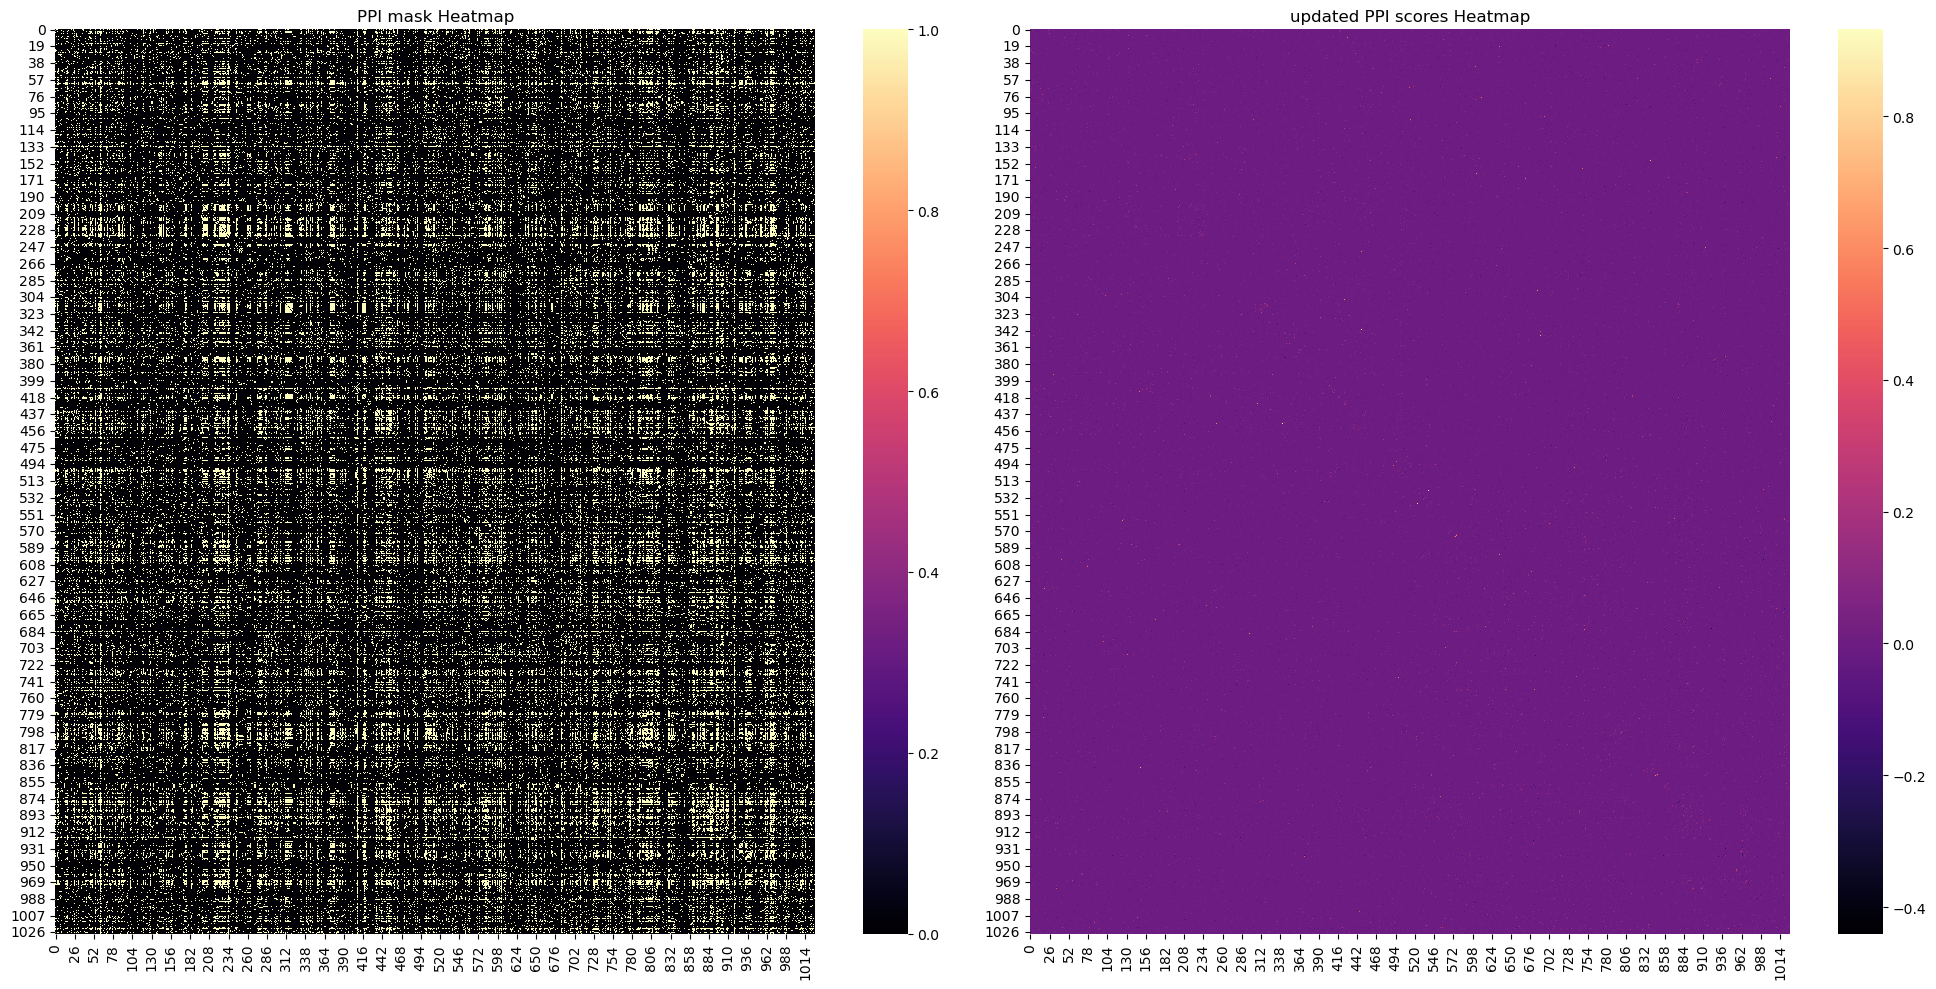

In [24]:
#and now the updated ppi
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Create a figure with two subplots side by side

# Heatmap for ppi.ppi
sns.heatmap(ppi.mask, ax=axes[0], cmap='magma')
axes[0].set_title('PPI mask Heatmap')

# Heatmap for ppi.maks
sns.heatmap(updated_ppi, ax=axes[1], cmap='magma')
axes[1].set_title('updated PPI scores Heatmap')

# Display the plot
plt.tight_layout()
plt.show()


(77543,)


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00,
        1.5000e+01, 1.8000e+01, 2.9000e+01, 3.2000e+01, 8.8000e+01,
        1.4500e+02, 3.3300e+02, 7.3000e+02, 1.5190e+03, 3.8310e+03,
        9.4120e+03, 1.8424e+04, 1.9171e+04, 1.0563e+04, 5.0980e+03,
        2.7940e+03, 1.6480e+03, 1.0340e+03, 6.5300e+02, 4.4300e+02,
        3.3700e+02, 2.3800e+02, 1.9300e+02, 1.4600e+02, 1.0900e+02,
        9.5000e+01, 6.9000e+01, 5.8000e+01, 5.1000e+01, 3.6000e+01,
        2.8000e+01, 2.9000e+01, 1.7000e+01, 1.3000e+01, 1.5000e+01,
        1.5000e+01, 1.3000e+01, 7.0000e+00, 9.0000e+00, 6.0000e+00,
        5.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00,
        3.0000e+00, 6.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 3.0000e+00, 3.0000e+00, 1.00

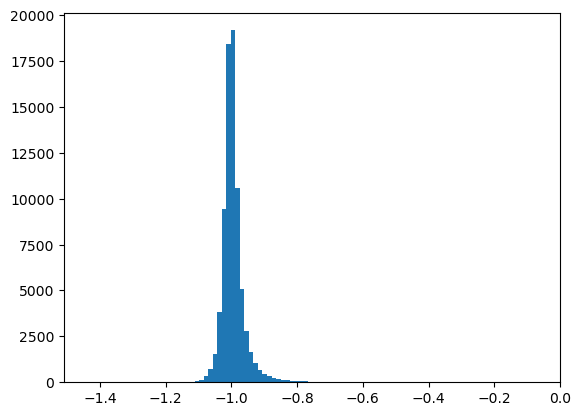

In [30]:
#now we do a histogram showing the changes of the nonzero elements
linearize_mask = ppi.linearize(ppi.mask)
linearize_updated = ppi.linearize(updated_ppi)

#now we need to find the nonzero elements

nonzero_mask = linearize_mask[linearize_mask != 0]
nonzero_updated = linearize_updated[linearize_updated != 0]
print(nonzero_mask.shape)
#now we plot the histogram
diff_array = nonzero_updated - nonzero_mask

plt.hist(diff_array, bins = 100)

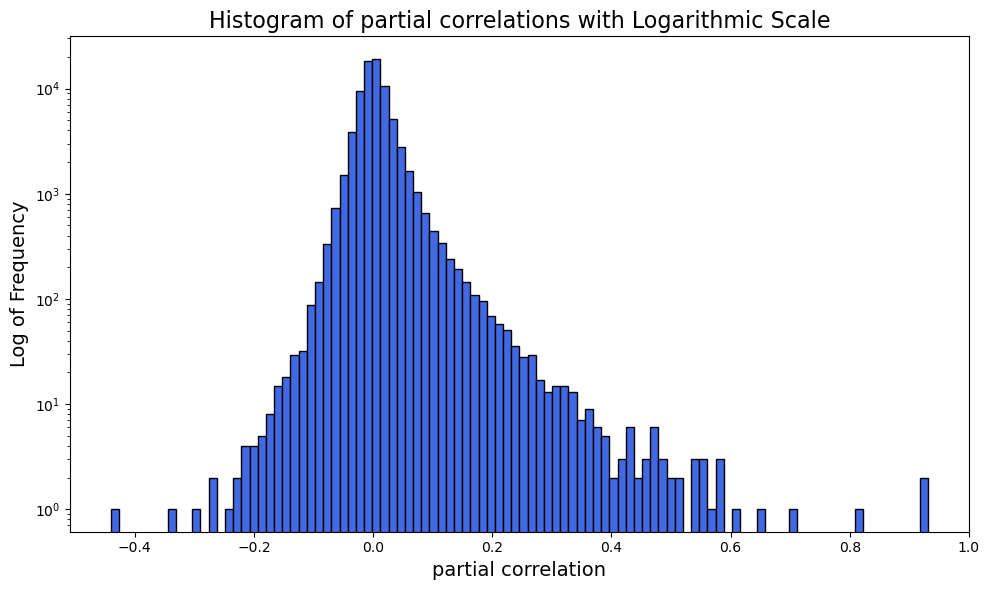

In [45]:
#and now a histogram of the nonzero elements of updated in general

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

plt.hist(nonzero_updated, bins=100, color='royalblue', edgecolor='black')  # Create histogram with styling

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('partial correlation', fontsize=14)  # X-axis label
plt.ylabel('Log of Frequency', fontsize=14)  # Y-axis label
plt.title('Histogram of partial correlations with Logarithmic Scale', fontsize=16)  # Title of the plot

#plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add a grid for easier reading, including minor grid lines

# Uncomment the following line if you want to set x-axis limits
# plt.xlim(-0.2, 0.3)

plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()  # Display the plot
#print('')

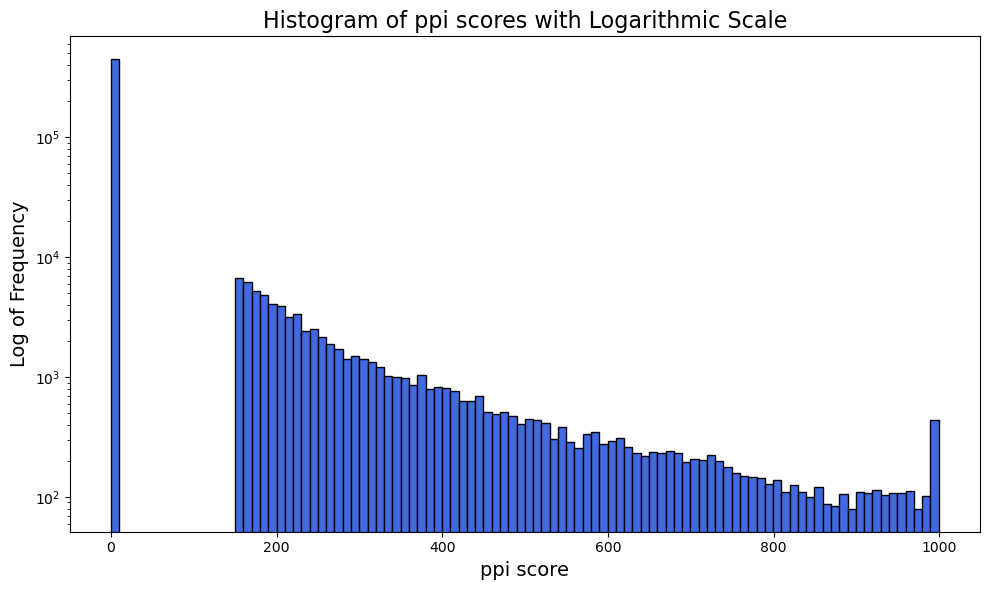

In [46]:
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

plt.hist(ppi.linearize(ppi.ppi), bins=100, color='royalblue', edgecolor='black')  # Create histogram with styling

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('ppi score', fontsize=14)  # X-axis label
plt.ylabel('Log of Frequency', fontsize=14)  # Y-axis label
plt.title('Histogram of ppi scores with Logarithmic Scale', fontsize=16)  # Title of the plot

#plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add a grid for easier reading, including minor grid lines

# Uncomment the following line if you want to set x-axis limits
# plt.xlim(-0.2, 0.3)

plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()  # Display the plot

In [53]:
#sort updated_ppi and find the i and j indices of the top 10% of the values

matrix = updated_ppi

# Step 1: Flatten the matrix
flat_matrix = matrix.flatten()

# Step 2: Get the indices of the top 3 values in the flattened array
top_3_indices_flat = np.argsort(flat_matrix)[-3:][::-1]  # argsort returns indices that would sort the array

# Step 3: Convert these indices back to 2D indices
top_3_indices_2d = np.unravel_index(top_3_indices_flat, matrix.shape)

# Print results
for index in zip(top_3_indices_2d[0], top_3_indices_2d[1]):
    print(f"Value: {matrix[index]}, Index: {index}")

Value: 0.9318195220990367, Index: (341, 448)
Value: 0.9318195220990367, Index: (448, 341)
Value: 0.921899095872345, Index: (562, 983)
Value: 0.921899095872345, Index: (983, 562)
Value: 0.8099199128806366, Index: (524, 538)
Value: 0.8099199128806366, Index: (538, 524)
Value: 0.6994978450451664, Index: (839, 149)
Value: 0.6994978450451664, Index: (149, 839)
Value: 0.6482375759713369, Index: (347, 690)
Value: 0.6482375759713369, Index: (690, 347)
Value: 0.6037898050514968, Index: (686, 296)
Value: 0.6037898050514968, Index: (296, 686)
Value: 0.5872679822310337, Index: (307, 425)
Value: 0.5872679822310337, Index: (425, 307)
Value: 0.5853750837692516, Index: (603, 163)
Value: 0.5853750837692516, Index: (163, 603)
Value: 0.5840986738467765, Index: (635, 596)
Value: 0.5840986738467765, Index: (596, 635)
Value: 0.570979113440191, Index: (848, 846)
Value: 0.570979113440191, Index: (846, 848)
Value: 0.5577926942457581, Index: (448, 252)
Value: 0.5577926942457581, Index: (252, 448)
Value: 0.55010

In [49]:
print(ppi.p_dict[341])
print(ppi.p_dict[448])

['CADPS', 'Calcium-dependent secretion activator 1']
['CD4', 'T-cell surface glycoprotein CD4']


In [51]:
ppi.ppi[341,448]

590.0

In [55]:
top_3_indices_flat = np.argsort(flat_matrix)[-10:][::-1]  # argsort returns indices that would sort the array

# Step 3: Convert these indices back to 2D indices
top_3_indices_2d = np.unravel_index(top_3_indices_flat, matrix.shape)

# Print results
for index in zip(top_3_indices_2d[0], top_3_indices_2d[1]):
    print(f"Value: {matrix[index]}, Index: {index}, names {ppi.p_dict[index[0]]}, {ppi.p_dict[index[1]]}, score {ppi.ppi[index[0],index[1]]}")

Value: 0.9318195220990367, Index: (341, 448), names ['CADPS', 'Calcium-dependent secretion activator 1'], ['CD4', 'T-cell surface glycoprotein CD4'], score 590.0
Value: 0.9318195220990367, Index: (448, 341), names ['CD4', 'T-cell surface glycoprotein CD4'], ['CADPS', 'Calcium-dependent secretion activator 1'], score 590.0
Value: 0.921899095872345, Index: (562, 983), names ['CHM', 'Rab proteins geranylgeranyltransferase component A 1'], ['F13B', 'Coagulation factor XIII B chain'], score 978.0
Value: 0.921899095872345, Index: (983, 562), names ['F13B', 'Coagulation factor XIII B chain'], ['CHM', 'Rab proteins geranylgeranyltransferase component A 1'], score 978.0
Value: 0.8099199128806366, Index: (524, 538), names ['CEP112', 'Centrosomal protein of 112 kDa'], ['CETN3', 'Centrin-3'], score 977.0
Value: 0.8099199128806366, Index: (538, 524), names ['CETN3', 'Centrin-3'], ['CEP112', 'Centrosomal protein of 112 kDa'], score 977.0
Value: 0.6994978450451664, Index: (839, 149), names ['DNMBP', 

Text(150, 0.8, 'Pearsons correlation: 0.152')

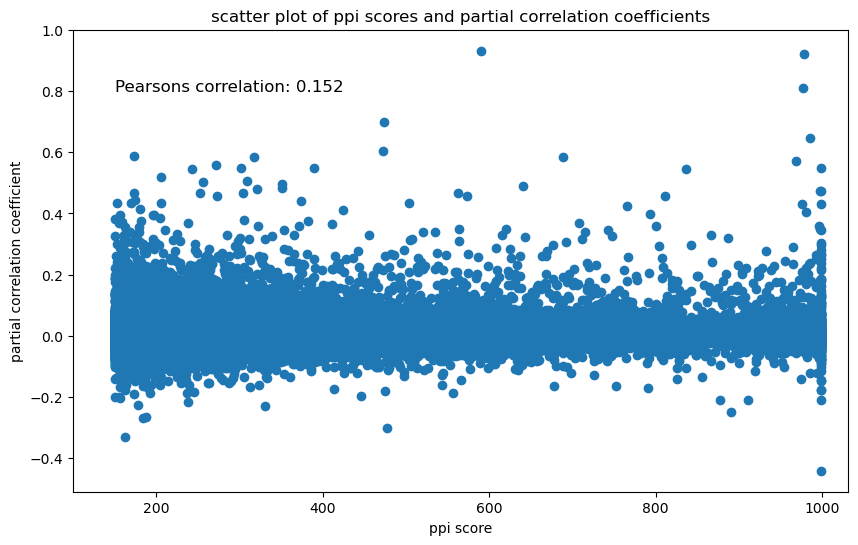

In [63]:
#do a scatter plot of ppi.ppi and updated_ppi
plt.figure(figsize=(10, 6))
plt.scatter(ppi.linearize(ppi.ppi), ppi.linearize(updated_ppi))
plt.xlabel('ppi score')
plt.ylabel('partial correlation coefficient')
plt.xlim(100, 1031)
plt.title('scatter plot of ppi scores and partial correlation coefficients')
#now find the correlation coefficient
from scipy.stats import pearsonr
corr, _ = pearsonr(ppi.linearize(ppi.ppi), ppi.linearize(updated_ppi))
#add it to the plot
plt.text(150, .8, 'Pearsons correlation: %.3f' % corr, fontsize=12)

In [ ]:
#let's do clustering on the ppi.ppi

